# Detecting outliers using STL residuals
Conda environment: `time-series`  
Feb 16 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [3]:
df = pd.read_csv("../datasets/example_retail_sales_with_outliers.csv",
                parse_dates=["ds"],
                index_col=["ds"])
df

,y
ds,
1992-01-01,"146,376.0000"
1992-02-01,"147,079.0000"
1992-03-01,"159,336.0000"
1992-04-01,"163,669.0000"
1992-05-01,"170,068.0000"
...,...
2004-12-01,"387,155.0000"
2005-01-01,"293,261.0000"
2005-02-01,"295,062.0000"


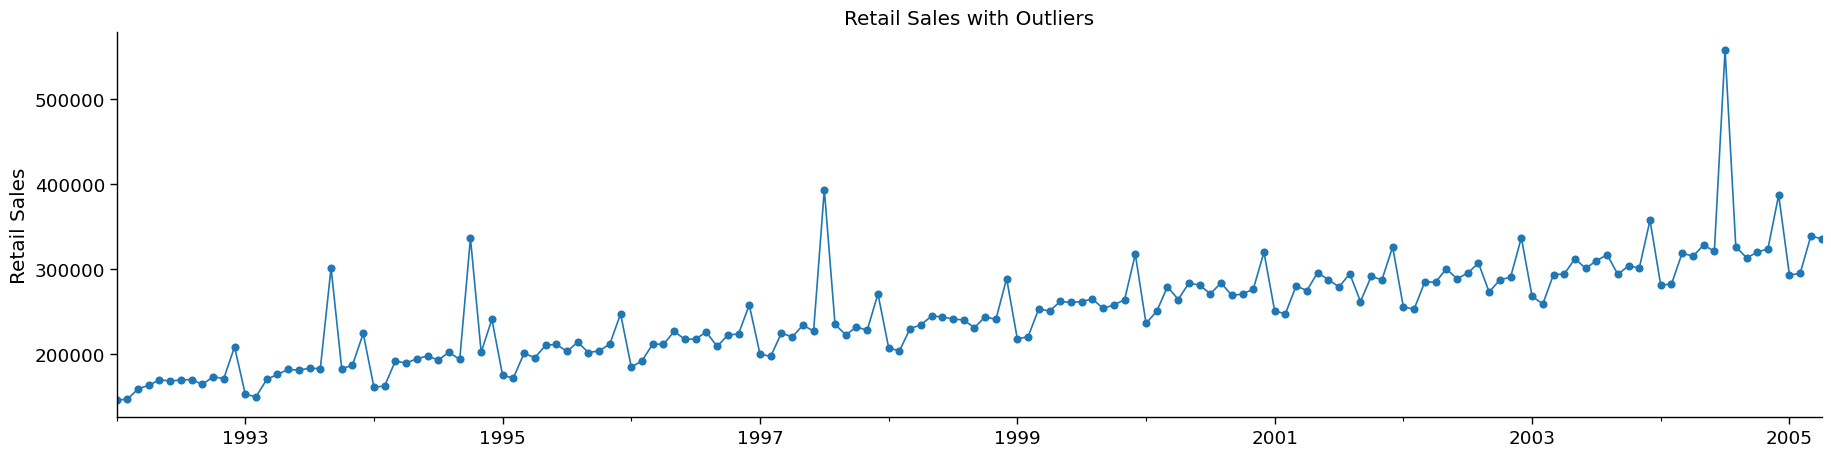

In [4]:
df.plot(marker="o", legend=None)

plt.title("Retail Sales with Outliers")
plt.ylabel("Retail Sales")
plt.xlabel("")
plt.show()

## 2) Identify outliers from STL residuals
The expected value: $\hat{y}_t$ is computed as follows:
$$\hat{y}_t = trend_t + seasonal_t$$
The residuals are defined as: $e_t = y_t - \hat{y}_t$

Then, the threshold is defined by the distance from the lower and upper quartiles of the residuals and does not depend on time:

$$\delta_{upper} = Q_3 + \alpha \times IQR$$
$$\delta_{lower} = Q_1 - \alpha \times IQR$$

$\alpha=1.5$ is a typical choice (99.7% of the data), however this can be adjusted depending on how sensitive you want the outlier detection to be.  
$\alpha=3$ for: $mean \pm 3*\sigma$ (99.9% of the data).

A data point is an outlier if:
$$e_t = y_t - \hat{y}_t > \delta_{upper}$$
$$e_t = y_t - \hat{y}_t < \delta_{lower}$$

In [5]:
# Copy the input df
df_ = df.copy(deep=True)

# Apply STL decomposition with default parameters except for robust for outliers
res = STL(endog= df_["y"], robust=True).fit()

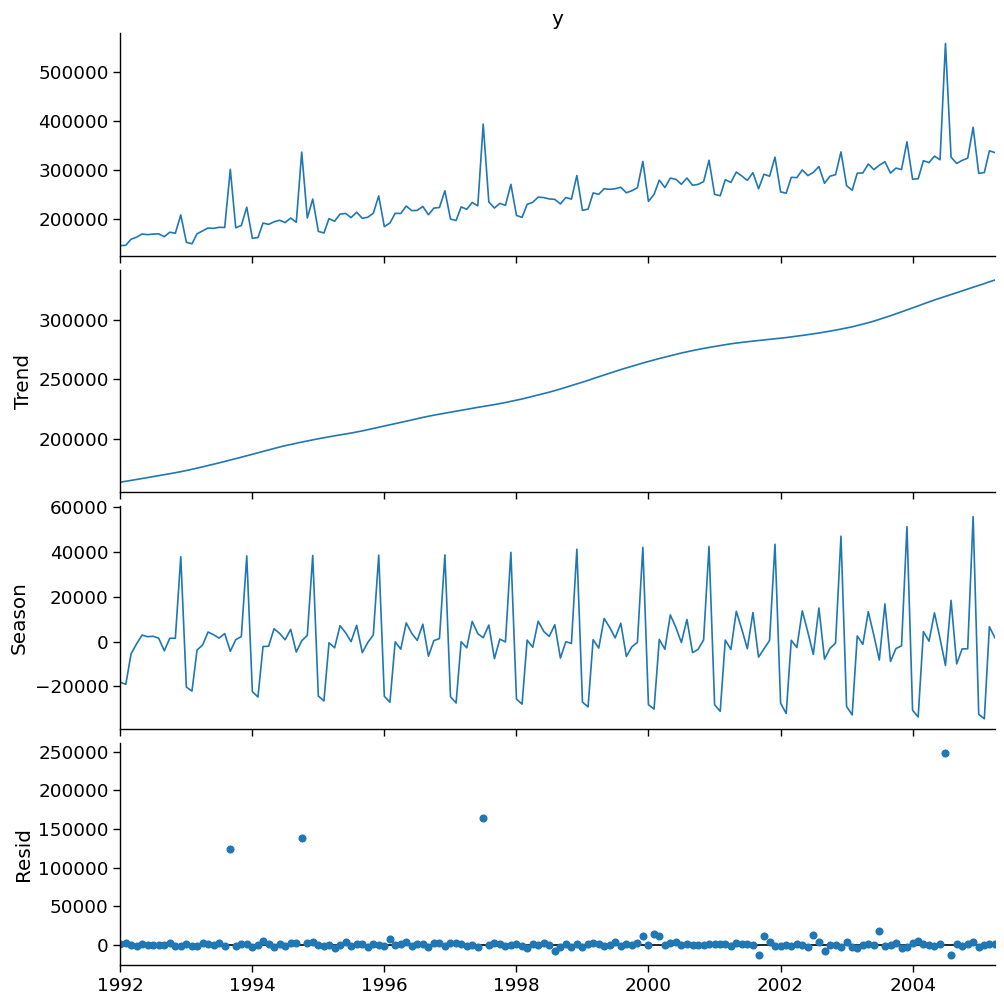

In [6]:
# Plot configs
plt.rc("font", size=5)
plt.rc("figure", figsize=(10, 10))

res.plot()
plt.show()

In [7]:
df_["residual"] = res.resid

# Compute IQR
Q1 = df_["residual"].quantile(0.25)
Q3 = df_["residual"].quantile(0.75)
IQR = Q3 - Q1

# Apply alpha*IQR as a threshold to identify outliers
# alpha = 3
alpha = 5
df_["lower"] = Q1 - alpha * IQR
df_["upper"] = Q3 + alpha * IQR
df_["is_outlier"] = (df_["residual"] < (Q1 - alpha * IQR)) | (df_["residual"] > (Q3 + alpha * IQR))

# Add estimated values
df_["yhat = seasonal + trend"] = res.seasonal + res.trend

# See df and count outliers
num_outliers = df_[df_["is_outlier"] == True].shape
print(f"Number of outliers: {num_outliers[0]}")
df_.head()

Number of outliers: 5


,y,residual,lower,upper,is_outlier,yhat = seasonal + trend
ds,,,,,,
1992-01-01,"146,376.0000",984.6531,"-15,761.3876","15,884.9299",False,"145,391.3469"
1992-02-01,"147,079.0000","1,922.8201","-15,761.3876","15,884.9299",False,"145,156.1799"
1992-03-01,"159,336.0000",-233.7738,"-15,761.3876","15,884.9299",False,"159,569.7738"
1992-04-01,"163,669.0000","-1,218.1916","-15,761.3876","15,884.9299",False,"164,887.1916"
1992-05-01,"170,068.0000",548.9785,"-15,761.3876","15,884.9299",False,"169,519.0215"


### 2.1) Plot outliers

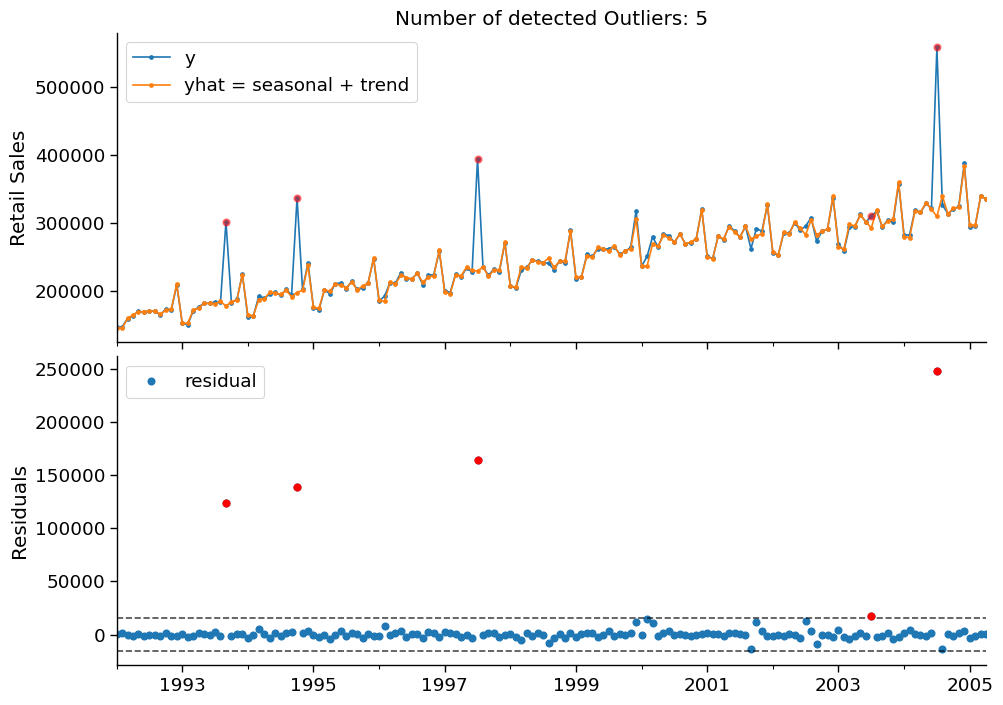

In [11]:
# Plot outliers
fig, ax = plt.subplots(nrows=2, figsize=[10, 7], sharex=True)

# Plot 1
df_.plot(y=["y", "yhat = seasonal + trend"], marker=".", ax=ax[0])

# Plot 2
df_.plot(y=["residual"], ax=ax[1], marker="o", linestyle="")
df_.plot(y=["upper", "lower"], ax=ax[1], color="k", legend=None, alpha=0.7, linestyle="dashed")

# Highlight residuals
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5)
    df_["residual"].loc[df_["is_outlier"]].plot(marker="o", color="r", ax=ax[1], legend=None, linestyle="")

ax[0].set_title(f"Number of detected Outliers: {num_outliers[0]}")
ax[0].set_ylabel("Retail Sales")
ax[1].set_ylabel("Residuals")
ax[1].set_xlabel("")

plt.tight_layout()

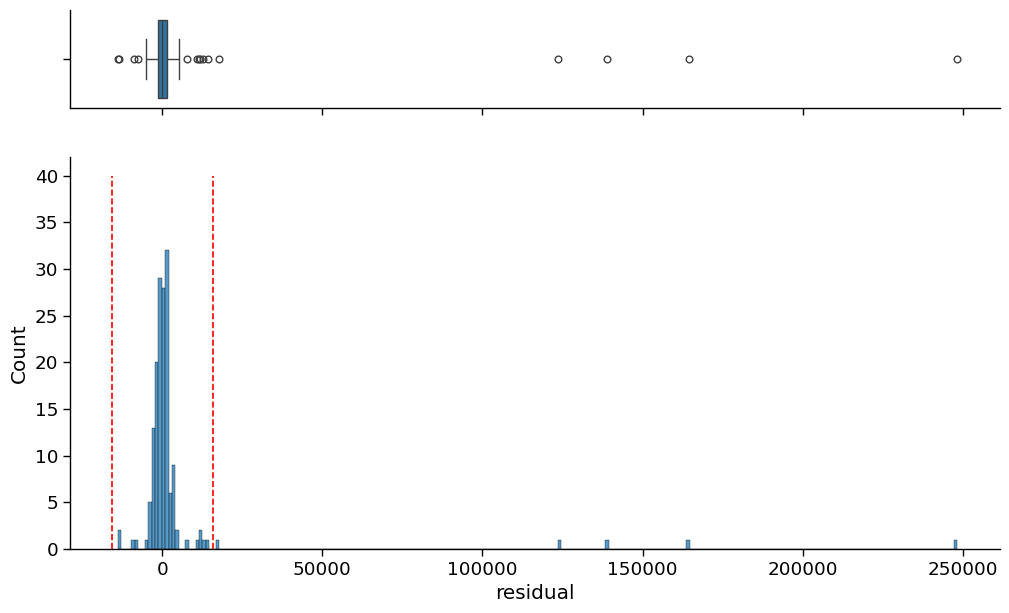

In [9]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}, figsize=[12, 7])

sns.boxplot(x=df_["residual"], ax=ax_box)
sns.histplot(x=df_["residual"], ax=ax_hist)
ax_hist.vlines(Q1 - alpha * IQR, 0, 40, color="r", linestyles="dashed")
ax_hist.vlines(Q3 + alpha * IQR, 0, 40, color="r", linestyles="dashed")

plt.show()

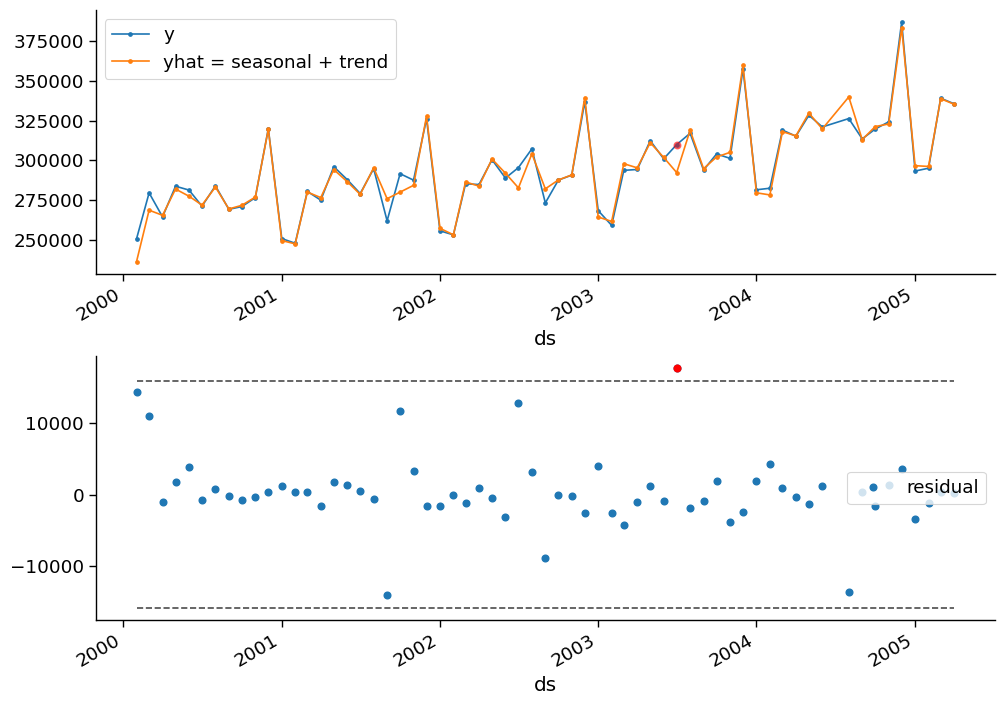

In [10]:
# Let's zoom in and see what's happening with non-obvious outliers
mask = (df_.index > '2000') & (df_["residual"] < 5e4)
df_masked = df_[mask]

fig, ax = plt.subplots(nrows=2, figsize= (10,7))

# Plot 1
df_masked.plot(y=["y", "yhat = seasonal + trend"], marker=".", ax=ax[0])

# Plot 2
df_masked.plot(y=["residual"], ax=ax[1], marker="o", linestyle="")
df_masked.plot(y=["upper", "lower"], ax=ax[1], color="k", legend=None, alpha=0.7, linestyle="dashed")

# Highlight residuals
if df_["is_outlier"].any():
    df_masked["y"].loc[df_masked["is_outlier"]].plot(marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5)
    df_masked["residual"].loc[df_masked["is_outlier"]].plot(marker="o", color="r", ax=ax[1], legend=None, linestyle="")

plt.tight_layout()

## 3) Removing Outliers

In [12]:
# Set outliers to NaN
df_.loc[df_["is_outlier"], "y"] = np.NaN

# Apply linear interpolation
df_.interpolate(method="linear", inplace=True)

# Add the seasonality extracted from STL back to deseasoned data
df_["y"] = df_["y"] + res.seasonal

df_.head()

,y,residual,lower,upper,is_outlier,yhat = seasonal + trend
ds,,,,,,
1992-01-01,"128,258.5041",984.6531,"-15,761.3876","15,884.9299",False,"145,391.3469"
1992-02-01,"127,963.8757","1,922.8201","-15,761.3876","15,884.9299",False,"145,156.1799"
1992-03-01,"153,863.2954",-233.7738,"-15,761.3876","15,884.9299",False,"159,569.7738"
1992-04-01,"162,734.5006","-1,218.1916","-15,761.3876","15,884.9299",False,"164,887.1916"
1992-05-01,"172,978.8685",548.9785,"-15,761.3876","15,884.9299",False,"169,519.0215"


### 3.1) Plot before and after imputation

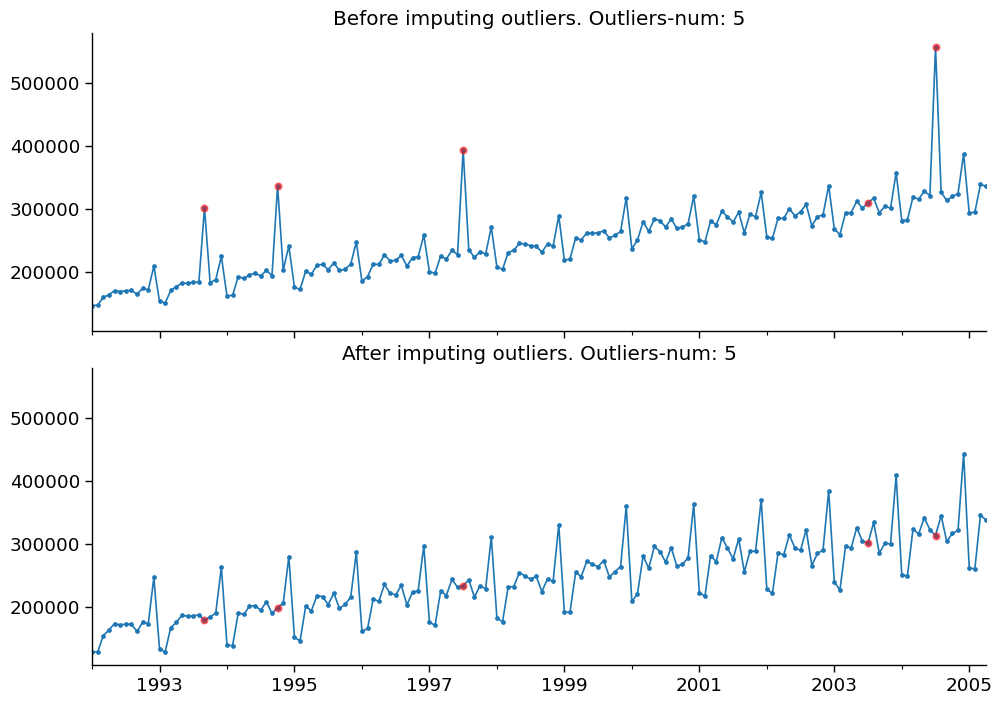

In [27]:
fig, ax = plt.subplots(nrows=2, figsize=[10, 7], sharex=True, sharey=True)

# Plot 1
df.plot(y="y", marker=".", title=f"Before imputing outliers. Outliers-num: {num_outliers[0]}", ax=ax[0], legend=None)
df[df_["is_outlier"]]["y"].plot(marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5)

# Plot 2
df_.plot(y=["y"], marker=".", title=f"After imputing outliers. Outliers-num: {num_outliers[0]}", ax=ax[1], legend=None)
df_[df_["is_outlier"]]["y"].plot(marker="o", color="r", ax=ax[1], legend=None, linestyle="", alpha=0.5)

ax[1].set_xlabel("")
plt.tight_layout()